# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement different image models on MNIST using Estimator. 

Note the MODEL_TYPE; change it to try out different models

In [12]:
import os
PROJECT = 'qwiklabs-gcp-1df92de26ef35bfb' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'qwiklabs-gcp-1df92de26ef35bfb' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE='cnn'  # 'linear', 'dnn', 'dnn_dropout', or 'cnn'

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['MODEL_TYPE'] = MODEL_TYPE
os.environ['TFVERSION'] = '1.8'  # Tensorflow version

In [13]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Run as a Python module

In the previous notebook (mnist_linear.ipynb) we ran our code directly from the notebook.

Now since we want to run our code on Cloud ML Engine, we've packaged it as a python module.

The `model.py` and `task.py` containing the model code is in <a href="mnistmodel/trainer">mnistmodel/trainer</a>

**Let's first run it locally for a few steps to test the code.** 

In [14]:
%bash
rm -rf mnistmodel.tar.gz mnist_trained
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   -- \
   --output_dir=${PWD}/mnist_trained \
   --train_steps=100 \
   --learning_rate=0.01 \
   --model=$MODEL_TYPE

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.one_hot on tensors.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
INFO:tensorflow:TF_CONFIG environment variable: {u'environment': u'cloud', u'cluster': {}, u'job': {u'args': [u'--output_dir=/content/datalab/training-data-analyst/courses/machine

**Now, let's do it on Cloud ML Engine so we can train on GPU (`--scale-tier=BASIC_GPU`)**

Note the GPU speed up depends on the model type. You'll notice the more complex CNN model trains significantly faster on GPU, however the speed up on the simpler models is not as pronounced.

In [16]:
%%writefile config.yaml
trainingInput:
  scaleTier: CUSTOM
  masterType: complex_model_m_gpu
  workerType: complex_model_m_gpu
  parameterServerType: large_model
  workerCount: 5
  parameterServerCount: 3

Overwriting config.yaml


In [17]:
%bash
OUTDIR=gs://${BUCKET}/mnist/trained_${MODEL_TYPE}
JOBNAME=mnist_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --config config.yaml \
   --runtime-version=$TFVERSION \
   -- \
   --output_dir=$OUTDIR \
   --train_steps=10000 --learning_rate=0.01 --train_batch_size=512 \
   --model=$MODEL_TYPE --batch_norm

gs://qwiklabs-gcp-1df92de26ef35bfb/mnist/trained_cnn us-central1 mnist_cnn_180926_080406
jobId: mnist_cnn_180926_080406
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [mnist_cnn_180926_080406] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe mnist_cnn_180926_080406

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs mnist_cnn_180926_080406


In [18]:
%%bash
gcloud ml-engine jobs describe mnist_cnn_180926_080406

createTime: '2018-09-26T08:04:12Z'
etag: 68mSUCw9o6Q=
jobId: mnist_cnn_180926_080406
state: PREPARING
trainingInput:
  args:
  - --output_dir=gs://qwiklabs-gcp-1df92de26ef35bfb/mnist/trained_cnn
  - --train_steps=10000
  - --learning_rate=0.01
  - --train_batch_size=512
  - --model=cnn
  - --batch_norm
  jobDir: gs://qwiklabs-gcp-1df92de26ef35bfb/mnist/trained_cnn
  masterType: complex_model_m_gpu
  packageUris:
  - gs://qwiklabs-gcp-1df92de26ef35bfb/mnist_cnn_180926_080406/aa10e0b1c10bac9ba0b97d67e0fae9471eb66cf0e6db09940c65cf7d222e1995/mnistmodel-0.1.tar.gz
  parameterServerCount: '3'
  parameterServerType: large_model
  pythonModule: trainer.task
  region: us-central1
  runtimeVersion: '1.8'
  scaleTier: CUSTOM
  workerCount: '5'
  workerType: complex_model_m_gpu
trainingOutput: {}



View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/mnist_cnn_180926_080406?project=qwiklabs-gcp-1df92de26ef35bfb

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fmnist_cnn_180926_080406&project=qwiklabs-gcp-1df92de26ef35bfb


## Monitoring training with TensorBoard

Use this cell to launch tensorboard

In [20]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/mnist/trained_{}'.format(BUCKET, MODEL_TYPE))

TensorBoard was started successfully with pid 5394. Click here to access it.

5394

In [19]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print 'Stopped TensorBoard with pid {}'.format(pid)

Stopped TensorBoard with pid 4473


Here's what it looks like with a linear model for 10,000 steps:
<img src="images/eval_linear_10000.png" width="60%"/>

Here are my results:

Model | Accuracy | Time taken | Model description | Run time parameters
--- | :---: | ---
linear | 91.53 | 3 min | | 100 steps, LR=0.01, Batch=512
linear | 92.73 | 8 min | | 1000 steps, LR=0.01, Batch=512
linear | 92.29 | 18 min | | 10000 steps, LR=0.01, Batch=512
dnn | 98.14 | 15 min | 300-100-30 nodes fully connected | 10000 steps, LR=0.01, Batch=512
dnn | 97.99 | 48 min | 300-100-30 nodes fully connected | 100000 steps, LR=0.01, Batch=512
dnn_dropout | 97.84 | 29 min | 300-100-30-DL(0.1)- nodes | 20000 steps, LR=0.01, Batch=512
cnn | 98.97 | 35 min | maxpool(10 5x5 cnn, 2)-maxpool(20 5x5 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 98.93 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 99.17 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits only) | 20000 steps, LR=0.01, Batch=512
cnn | 99.27 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits, deep) | 10000 steps, LR=0.01, Batch=512
cnn | 99.48 | 12 hr | as-above but nfil1=20, nfil2=27, dprob=0.1, lr=0.001, batchsize=233 | (hyperparameter optimization)

## Deploying and predicting with model

Deploy the model:

In [23]:
%bash
MODEL_NAME="mnist_cnn"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained_${MODEL_TYPE}/export/exporter | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION

Deleting and deploying mnist_cnn cnn from gs://qwiklabs-gcp-1df92de26ef35bfb/mnist/trained_cnn/export/exporter/1537949617/ ... this will take a few minutes


Created ml engine model [projects/qwiklabs-gcp-1df92de26ef35bfb/models/mnist_cnn].
Creating version (this might take a few minutes)......
.......................................................................................................done.


To predict with the model, let's take one of the example images.

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


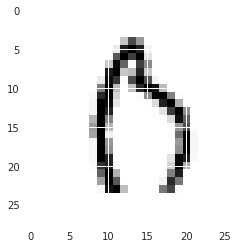

In [30]:
import json, codecs
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

HEIGHT=28
WIDTH=28

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
IMGNO=324 #CHANGE THIS to get different images
jsondata = {'image': mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()}
json.dump(jsondata, codecs.open('test.json', 'w', encoding='utf-8'))
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

Send it to the prediction service

In [31]:
%bash
gcloud ml-engine predict \
   --model=mnist_cnn \
   --version=${MODEL_TYPE} \
   --json-instances=./test.json

CLASSES  PROBABILITIES
0        [0.9999808073043823, 1.6041292838053778e-05, 2.421472133917746e-09, 8.47921732827217e-09, 8.515640104178601e-08, 1.5568206279681363e-08, 4.874199248661171e-07, 3.11037979372486e-07, 2.3046725345921004e-06, 8.748405888603372e-10]


## DO NOT RUN anything beyond this point

This shows you what I did, but trying to repeat this will take several hours.

<br/>

## Hyperparameter tuning
This is what `hyperparam.yaml` looked like:

In [ ]:
trainingInput:
  scaleTier: CUSTOM
  masterType: complex_model_m_gpu
  hyperparameters:
    goal: MAXIMIZE
    maxTrials: 30
    maxParallelTrials: 2
    hyperparameterMetricTag: accuracy
    params:
    - parameterName: train_batch_size
      type: INTEGER
      minValue: 32
      maxValue: 512
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: learning_rate
      type: DOUBLE
      minValue: 0.001
      maxValue: 0.1
      scaleType: UNIT_LOG_SCALE
    - parameterName: nfil1
      type: INTEGER
      minValue: 5
      maxValue: 20
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: nfil2
      type: INTEGER
      minValue: 10
      maxValue: 30
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: dprob
      type: DOUBLE
      minValue: 0.1
      maxValue: 0.6
      scaleType: UNIT_LINEAR_SCALE

This takes <b>13 hours and 250 ML Units</b>, so don't try this at home :)

The key thing is here the --config parameter. 

In [ ]:
%bash
OUTDIR=gs://${BUCKET}/mnist/trained_${MODEL_TYPE}_hparam
JOBNAME=mnist_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --runtime-version=$TFVERSION \
   --config hyperparam.yaml \
   -- \
   --output_dir=$OUTDIR \
   --model=$MODEL_TYPE --batch_norm

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>